# Comparison of nestle, dynesty, emcee, zeus, pymultinest and ultranest

Here we compare a few open-source Bayesian samplers, looking at:

* features
* correctness in posterior distributions
* correctness in evidence estimates
* performance (wall-clock time)

Lets give an overview of the features:

| Sampler             | emcee | zeus | (py)multinest | nestle | dynesty | ultranest |
|---------------------|-------|------|---------------|--------|---------|-----------|
| Parameter estimation| ✓     | ✓    | ✓             | ✓      | ✓       | ✓         |
| Evidence estimation |       |      | ✓             | ✓      | ✓       | ✓         |
| Automatic starting  |       |      | ✓             | ✓      | ✓       | ✓         |
| Automatic terminating|      |      | ✓             | ✓      | ✓       | ✓         |
| Resume from disk    |       |      | ✓             |        |         | ✓         |
| Parallelisation     | ✓     | ✓    | ✓             |        | ✓       | ✓         |
| Circular parameters |       |      | ✓             |        | ✓       | ✓         |
| Plot during run     | ✓     | ✓    |               |        |         | ✓         |

emcee requires the user to define a start point and to test convergence criteria on the chains to define the end point, while the other packages automate this.

Here are some convenience functions for running the samplers, parsing their output and measuring their speed:

In [1]:
import numpy as np
import time
import joblib
import os
import numpy as np
import corner
import matplotlib.pyplot as plt
mem = joblib.Memory('.', verbose=False)

In [2]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

def run_sampler_for(func):

    @contextmanager
    def time_limit(seconds):
        def signal_handler(signum, frame):
            raise TimeoutException("Timed out!")
        signal.signal(signal.SIGALRM, signal_handler)
        signal.alarm(seconds)
        try:
            yield
        finally:
            signal.alarm(0)

    def runfunc(*args, **kwargs):
        max_duration = 10 * 60 # 10 minutes maximum runtime
        try:
            with time_limit(max_duration):
                return func(*args, **kwargs)
        except TimeoutException as e:
            return None, None, None
    return runfunc

In [3]:
@mem.cache
@run_sampler_for
@mem.cache
def run_sampler(
    samplername,
    param_names,
    loglike,
    transform=None,
    vectorized=False,
    max_ncalls = 400000000
):
    """Initialise sampler.

    Parameters
    -----------
    samplername: str
        one of: multinest, dynesty, ultranest, zeus, goodman-weare
    param_names: list of str, names of the parameters.
        Length gives dimensionality of the sampling problem.

    loglike: function
        log-likelihood function.
        Receives multiple parameter vectors, returns vector of likelihood.
    transform: function
        parameter transform from unit cube to physical parameters.
        Receives multiple cube vectors, returns multiple parameter vectors.
    vectorized: bool
        if true, likelihood and transform receive arrays of points, and return arrays
    max_ncalls: int
        maximum number of likelihood evaluations
    """
    ndim = len(param_names)
    if vectorized:
        def flat_loglike(theta):
            L = loglike(theta.reshape((1, -1)))[0]
            assert np.isfinite(L), L
            return L
        
        def flat_transform(cube):
            return transform(cube.reshape((1, -1)))[0]
    else:
        flat_transform = transform
        flat_loglike = loglike
    t_start = time.time()
    if samplername == 'multinest':
        from pymultinest.solve import solve
        import pymultinest
        results = solve(LogLikelihood=flat_loglike, Prior=flat_transform, 
            n_dims=ndim,
            n_live_points=400,
            verbose=True, importance_nested_sampling=False,
            sampling_efficiency=0.3)
        samples = results.pop('samples')
        info = dict(logz=results['logZ'], logzerr=results['logZerr'])
        return info, samples, time.time() - t_start
    elif samplername == 'nestle':
        import nestle
        res = nestle.sample(flat_loglike, flat_transform, ndim,
            npoints=400, method='multi',
            callback=nestle.print_progress, maxcall=max_ncalls)
        results = dict(
            ncall=int(res.ncall),
            logz=float(res.logz),
            logzerr=float(res.logzerr),
        )
        weighted_samples, weights = res.samples, res.weights
        assert np.isclose(weights.sum(), 1), (weights.max(), weights.sum(), weights)
        samples = nestle.resample_equal(weighted_samples, weights)
        return results, samples, time.time() - t_start
    elif samplername == 'dynesty' or samplername == 'dynesty-multiell':
        from dynesty import DynamicNestedSampler
        from dynesty import utils as dyfunc
        if samplername == 'dynesty-multiell':
            sampler = DynamicNestedSampler(flat_loglike, flat_transform, ndim,
                bound='multi', sample='unif')
        else:
            sampler = DynamicNestedSampler(flat_loglike, flat_transform, ndim)
        sampler.run_nested(maxcall=max_ncalls, nlive_init=100, maxiter_init=10, nlive_batch=100)
        res = sampler.results
        results = dict(
            ncall=int(sum(res.ncall)),
            logz=float(res.logz[-1]),
            logzerr=float(res.logzerr[-1]),
        )
        weighted_samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        samples = dyfunc.resample_equal(weighted_samples, weights)
        return results, samples, time.time() - t_start
    elif samplername == 'ultranest':
        from ultranest import ReactiveNestedSampler
        sampler = ReactiveNestedSampler(param_names, loglike, transform=transform, 
            vectorized=vectorized)
        results = sampler.run(max_ncalls=max_ncalls)
        sampler.print_results()
        return results, results['samples'], time.time() - t_start
    elif samplername in ('goodman-weare', 'slice'):
        from autoemcee import ReactiveAffineInvariantSampler
        sampler = ReactiveAffineInvariantSampler(param_names, loglike, transform=transform, 
            sampler=samplername, vectorized=vectorized)
        results = dict(sampler.run(max_ncalls=max_ncalls))
        sampler.print_results()
        samples = results.pop('samples')
        return results, samples, time.time() - t_start


## Problem 1) Hyper-rectangle

This is a very simple problem with the likelihood: 

$$ L=\left|\theta-\frac{1}{2}\right|$$

defined over the unit hypercube, and L capped at $e^{100}$.

The contours of this likelihood are d-dimensional rectangles.

Define the problem:

In [4]:
ndim = 5
paramnames = ['param%d' % (i+1) for i in range(ndim)]

In [5]:
def loglike(theta):
    delta = np.max(np.abs(theta - 0.5), axis=1)
    volume_enclosed = theta.shape[1] * np.log(delta + 1e-15)
    like = -volume_enclosed
    like[~(like < +100)] = 100
    return like
def transform(x):
    return x


Run some of the samplers on it:

In [6]:
## all_samplers = ['goodman-weare', 'multinest', 'ultranest', 'dynesty']
all_samplers = ['goodman-weare', 'slice', 'multinest', 'ultranest', 'nestle', 'dynesty']
all_results = [(samplername, *run_sampler(samplername, paramnames, loglike, transform, vectorized=True)) for samplername in all_samplers]

423it [00:30, 14.38it/s, batch: 3 | bound: 0 | nc: 13278 | ncall: 76833 | eff(%):  0.551 | loglstar: 15.357 < 15.589 < 18.943 | logz:  5.843 +/-  2.502 | stop: 58.076]


## Results


### Correctness of logZ

Lets look at the logZ estimates:

In [7]:
for samplername, info, samples, duration in all_results:
    if samples is not None:
        print('%14s   %5.1fs   %5.3f %s' % (samplername, duration, np.percentile(samples[:,0], 95), info.get('logz')))
    else:
        print('%14s   failed to terminate' % (samplername))

 goodman-weare     0.3s   0.778 None
         slice   failed to terminate
     multinest    27.8s   0.534 8.096733259979857
     ultranest    69.9s   0.530 8.10030705199884
        nestle   116.0s   0.526 8.196238900241699
       dynesty   failed to terminate


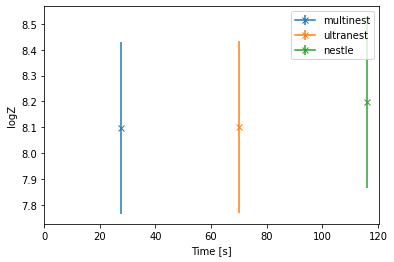

In [8]:
for samplername, info, samples, duration in all_results:
    if info and 'logz' in info:
        plt.errorbar(x=duration, y=info['logz'], yerr=info['logzerr'], marker='x', label=samplername)
plt.legend()
plt.xlabel('Time [s]')
plt.xlim(0, None)
plt.ylabel('logZ');

This paper https://ui.adsabs.harvard.edu/abs/2016S%26C....26..383B/abstract
showed that multinest (=dynesty, =nestle) sampling is biased on this problem, while ultranest's sampling is unbiased.

The differences do not show up here, yet, but I'd be cautious.

You can see that multinest is a bit faster than ultranest, which is faster than nestle. dynesty, never terminating, is the slowest by far.

### Correctness of posterior

Since all parameters are equal, we just plot a histogram of the first parameter's posterior samples:

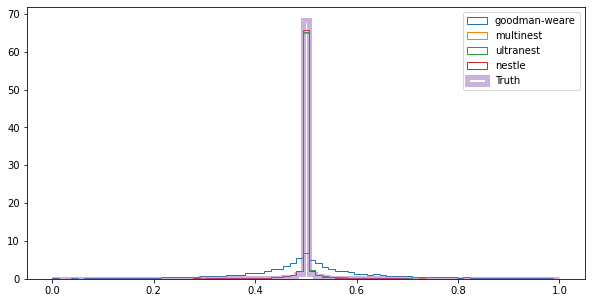

In [9]:
plt.figure(figsize=(10,5))
bins = np.linspace(0, 1, 80)
for samplername, info, samples, duration in all_results:
    if samples is not None:
        plt.hist(samples[:,0], label=samplername, histtype='step', bins=bins, density=True)

points = np.random.uniform(0, 1, size=(10000000,1))
weights = np.exp(loglike(points))
plt.hist(points[np.random.choice(len(points), p=weights / weights.sum(), size=100000),0],
         bins=bins, density=True, label='Truth', histtype='step', ls='-', lw=5, alpha=0.5)
plt.legend();


That's odd, emcee (=goodman-weare) has extremely wide tails here, while all the nested samplers are more or less similar.

Lets plot two parameters of the emcee samples:

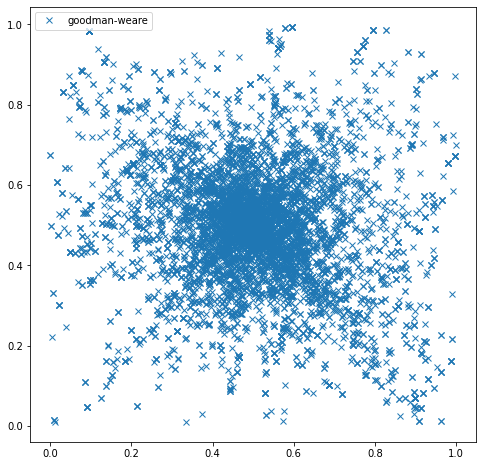

In [10]:
plt.figure(figsize=(8, 8))
#plt.plot(all_results[-1][2][:,0], all_results[-1][2][:,1], 'o', label=all_results[-1][0]);
plt.plot(all_results[0][2][2000::4,0], all_results[0][2][2000::4,1], 'x', label=all_results[0][0]);
plt.legend();

emcee, by its line sampling, is oversampling the corners giving it too much weight.

--> **emcee is biased**. emcee is dangerous for non-gaussian likelihoods

We have run emcee here until the autocorrelation shows no biases, and discarded warmup points.

--> **emcee** also does not tell you when its results are biased.


# Problem 2) Loggamma

The loggamma problem consists of four peaks, with a mix of gaussian and heavy tails.

There are a few papers that look at this, including https://ui.adsabs.harvard.edu/abs/2016S%26C....26..383B/abstract https://ui.adsabs.harvard.edu/abs/2013arXiv1304.7808B/abstract https://ui.adsabs.harvard.edu/abs/2019OJAp....2E..10F/abstract
which find that multinest (=nestle, =dynesty)'s sampling is biased here.

Define the problem:

In [11]:
ndim_gamma = 14
paramnames_gamma = ['param%d' % (i+1) for i in range(ndim_gamma)]

import scipy.stats
from numpy import log
scale = 1./30
rv1a = scipy.stats.loggamma(1, loc=2./3, scale=scale)
rv1b = scipy.stats.loggamma(1, loc=1./3, scale=scale)
rv2a = scipy.stats.norm(2./3, scale)
rv2b = scipy.stats.norm(1./3, scale)
rv_rest = []
for i in range(2, ndim):
    if i <= (ndim+2) // 2:
        rv = scipy.stats.loggamma(1, loc=2./3., scale=scale)
    else:
        rv = scipy.stats.norm(2./3, scale)
    rv_rest.append(rv)
    del rv

def loglike_loggamma(theta):
    with np.errstate(divide='ignore'):
        L1 = log(0.5 * rv1a.pdf(theta[:,0]) + 0.5 * rv1b.pdf(theta[:,0]) + 1e-300)
        L2 = log(0.5 * rv2a.pdf(theta[:,1]) + 0.5 * rv2b.pdf(theta[:,1]) + 1e-300)
        Lrest = np.sum([rv.logpdf(t) for rv, t in zip(rv_rest, theta[:,2:].transpose())], axis=0)
        like = L1 + L2 + Lrest
        like = np.where(like < -1e300, -1e300 - ((np.asarray(theta) - 0.5)**2).sum(), like)
        assert like.shape == (len(theta),), (like.shape, theta.shape)
        return like


In [19]:
all_samplers = ['goodman-weare', 'slice', 'multinest', 'nestle', 'dynesty', 'ultranest']
all_results = [(samplername, *run_sampler(samplername, paramnames_gamma, loglike_loggamma, transform, vectorized=True)) for samplername in all_samplers]

In [20]:
for samplername, info, samples, duration in all_results:
    if samples is not None:
        print('%14s   %5.1fs   %5.3f %s' % (samplername, duration, np.percentile(samples[:,0], 95), info.get('logz')))
    else:
        print('%14s   failed to terminate' % (samplername))

 goodman-weare     1.1s   0.686 None
         slice   failed to terminate
     multinest    16.6s   0.692 0.9731469527860832
        nestle   119.2s   0.691 0.667649014786495
       dynesty   failed to terminate
     ultranest   349.1s   0.697 0.07679646291904314


## Correctness of posterior

Lets plot the posterior in the first two parameters to illustrate the problem:

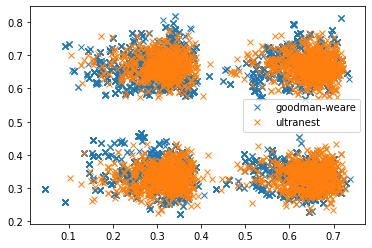

In [21]:
plt.plot(all_results[0][2][2000::4,0], all_results[0][2][2000::4,1], 'x', label=all_results[0][0]);
plt.plot(all_results[-1][2][:,0], all_results[-1][2][:,1], 'x', label=all_results[-1][0]);
plt.legend();

The posterior has four peaks. Emcee has been initialised uniformly over the space, so I am not tricking it into not discovering some peaks.

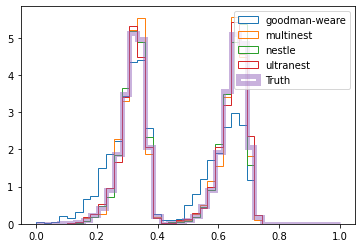

In [26]:
bins = np.linspace(0, 1, 40)
for samplername, info, samples, duration in all_results:
    if samples is not None:
        plt.hist(samples[:,0], label=samplername, histtype='step', bins=bins, density=True)

import scipy.stats
plt.hist(np.hstack((rv1a.rvs(size=10000), rv1b.rvs(size=10000))), label='Truth', histtype='step', bins=bins, density=True, lw=5, alpha=0.5)
plt.legend();


The emcee/goodman-weare posteriors do not look like a loggamma function, so emcee is wrong here. The others look okay.

## Correctness of logZ

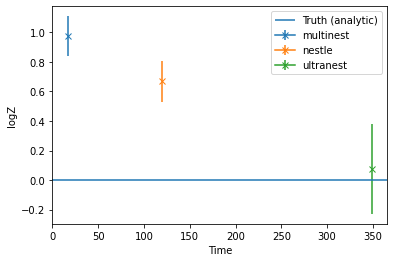

In [27]:
for samplername, info, samples, duration in all_results:
    if info and 'logz' in info:
        plt.errorbar(x=duration, y=info['logz'], yerr=info['logzerr'], marker='x', label=samplername)
plt.xlabel('Time')
_, xhi = plt.xlim()
plt.xlim(0, xhi)
plt.hlines(0, 0, xhi, label='Truth (analytic)')
plt.legend()
plt.ylabel('logZ');

Here we can see that multinest=nestle=dynesty overestimate logZ. 

In real-life cases even when the model was the correct model, such biases have been observed, for example here: https://ui.adsabs.harvard.edu/abs/2020AJ....159...73N/abstract


# Conclusions

* in terms of features, multinest and ultranest support *resume from disk*. emcee and ultranest allow seeing where the sampler is exploring during a run. *MPI parallelisation* is implemented in almost all samplers. Nested samplers terminate automatically, while emcee/zeus require careful convergence checks.
* **emcee** gives biased posteriors in these two problems. These biases are undetectable by convergence analyses.
* **zeus** recognized that it did not converge in the second problem, but then did not terminate in time.
* multi-ellipsoidal rejection nested sampling, as implemented in **multinest**, **nestle** and **dynesty** has biases in logZ estimation when the posterior has multimodal non-ellipsoidal contours.
* **dynesty** sometimes does not terminate.
* **ultranest** is not the fastest method
* **ultranest** is a careful hedgehog and gives the correct results out-of-the-box.

Please be careful with packages recommending and defaulting to emcee and dynesty. You may need to verify the results carefully when the posteriors are not gaussian.

Links:
* emcee: https://emcee.readthedocs.io/en/stable/
* zeus: https://zeus-mcmc.readthedocs.io/en/latest/
* autoemcee: https://github.com/JohannesBuchner/autoemcee/
* pymultinest: https://johannesbuchner.github.io/PyMultiNest/
* nestle: https://kbarbary.github.io/nestle
* dynesty: https://dynesty.readthedocs.io/en/latest/
* ultranest: https://johannesbuchner.github.io/UltraNest/
